In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.ndimage import convolve1d
import scipy.linalg as la

In [20]:
data_path = "data/Prague_Grayscale_small/"
dataset_size = 20

imgs = [] ; masks = [] ; ground_truth = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))
    ground_truth.append(skimage.io.imread(data_path + f'gt{i}_1.png'))

In [21]:
def beta3(x): #cubic B-spline (formula (A2) in the Appendix)
    ax = np.abs(x)
    y = np.zeros_like(ax, dtype=np.float64)
    mask1 = ax < 1
    mask2 = (ax >= 1) & (ax < 2)
    y[mask1] = 2/3 - ax[mask1]**2 + 0.5*ax[mask1]**3
    y[mask2] = ((2 - ax[mask2])**3) / 6
    return y

In [22]:
def bspline_kernel_1d(m): #discrete cubic B-spline kernel (formula (A1) in the Appendix)
    radius = int(np.ceil(2 * m))
    k = np.arange(-radius, radius + 1)
    kernel = beta3(k / m)
    kernel /= kernel.sum()
    return kernel

In [23]:
def spline_smooth_2d(X, m): #convolution operation performed at equation (27)
    kernel = bspline_kernel_1d(m)
    Y = convolve1d(X, kernel, axis=0, mode='mirror')
    Y = convolve1d(Y, kernel, axis=1, mode='mirror')
    return Y

In [24]:
def upsample_filter_1d(h, factor): #filter of the smoothing update block
    h = np.asarray(h, dtype=np.float64)
    if factor <= 1:
        return h
    out = np.zeros((len(h) - 1) * factor + 1, dtype=np.float64)
    out[::factor] = h
    return out

In [25]:
def two_scale_update_2d(Fm, m): #to go from m-scale features to 2m-scale features (equation (28) and formula (A6) in the Appendix)
    h = np.array([1, 4, 6, 4, 1], dtype=np.float64) / 16.0
    h_m = upsample_filter_1d(h, factor=m)
    F2m = convolve1d(Fm, h_m, axis=0, mode='mirror')
    F2m = convolve1d(F2m, h_m, axis=1, mode='mirror')
    return F2m

In [26]:
def two_scale_reduction(X1n, X2n, M, eps=1e-6): #to go from m-scale to 2m-scale
    S1 = np.cov(X1n, rowvar=False)
    S2 = np.cov(X2n, rowvar=False)
    S2 = S2 + eps * np.eye(S2.shape[0])
    vals, vecs = la.eigh(S1, S2)
    idx = np.argsort(vals)[::-1]
    vals = vals[idx]
    vecs = vecs[:, idx]
    T = vecs[:, :M]
    lambdas = vals[:M]
    W = X2n @ T
    return W

In [27]:
def unser_segmentation(X, K, m): #X is the image, K the number of clusters and m the size of the window
    H, W = X.shape

    coeffs = pywt.swt2(X, wavelet='haar', level=2) #we use the modern SWT as an approximation of the DWF
    cA2, (cH2, cV2, cD2) = coeffs[-1] #coarse level : cA2 is the lwo-pass subband, (cH2, cV2, cD2) are the horizontal, vertical and diagonal wavelet subbands
    cA1, (cH1, cV1, cD1) = coeffs[0] #fine level : idem
    Y = [cA2, cH2, cV2, cD2, cH1, cV1, cD1] #wavelet frame coefficients

    E = [Yi**2 for Yi in Y] #feature extraction is based on energy
    Fm  = [spline_smooth_2d(Ei, m) for Ei in E] #texture features at resolution m (i.e. local variance estimates)
    F2m = [two_scale_update_2d(Fi_m, m) for Fi_m in Fm] #texture features at resolution 2m (i.e. local variance estimates)

    Y1 = Y[0] #lowpass channel
    mean_lp_m  = spline_smooth_2d(Y1, m) #local mean of the lowpass at resolution m
    mean_lp_2m = two_scale_update_2d(mean_lp_m, m) #local mean of the lowpass at resolution 2m
    Fm[0]  = Fm[0]  - mean_lp_m**2 #true variance local estimate at resolution m
    F2m[0] = F2m[0] - mean_lp_2m**2 #true variance local estimate at resolution 2m
    for i in range(len(Fm)): #in case it goes wrong with the numerical approximations, a variance has to be positive
        Fm[i] = np.maximum(Fm[i], 0.0)
        F2m[i] = np.maximum(F2m[i], 0.0)

    Vm = np.stack(Fm, axis=-1)
    X1 = Vm.reshape(-1, Vm.shape[-1])
    V2m = np.stack(F2m, axis=-1)
    X2 = V2m.reshape(-1, V2m.shape[-1])
    X1c = X1 - X1.mean(axis=0, keepdims=True) #for the computation of the scatter matrix
    X2c = X2 - X2.mean(axis=0, keepdims=True) #idem
    M = K - 1 #the number of features kept
    Z = two_scale_reduction(X1c, X2c, M=M) #final features used for segmentation

    labels = KMeans(n_clusters=K, n_init=20, random_state=0).fit_predict(Z) #clustering is done in the feature space
    segmentation = labels.reshape(H, W)

    return segmentation

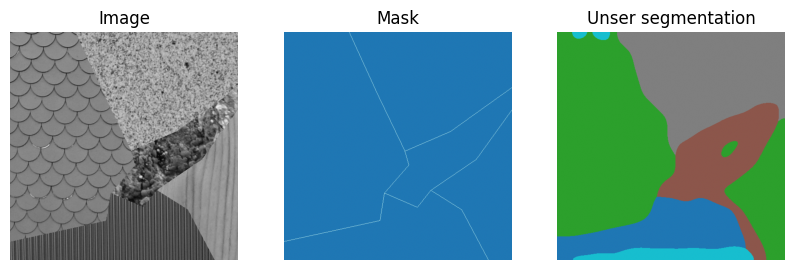

In [28]:
X=imgs[2].astype(np.float32)
X = (X - X.min()) / (X.max() - X.min())  #normalization in [0,1]

K = 5
m = 16

seg_twoscale = unser_segmentation(X, K, m)

plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(X, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(masks[2], cmap='tab20')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Unser segmentation")
plt.imshow(seg_twoscale, cmap='tab10')
plt.axis('off')

plt.show()

In [ ]:
#faire l'évaluaion ! 